# Env setups
(SAGINEnv_v1_1)

In [1]:
import numpy  as np

seed = 7    # often: 7, debugging: 42, 30
max_cycles = 300
uav_init_mode = 'specific'  # ['random', 'kmeans', 'specific']
# uav_init_locs = 1000 * np.array([
#     [-1, 1],
#     [-1, -1],
#     [1, -1]
# ]).transpose()
uav_init_locs = 1000 * np.array([
    [1, 1],
    [1, 1],
    [1, 1]
]).transpose()
user_mode = "random walk"   # "stationary", "random walk"
user_velocity = 1.5
link_assignment = "greedy (drate)"  # "greedy (drate)", "kmeans"
fading = True
deterministic = True

# For plotting
log_avg_drates_dict = dict()
log_n_satisfied_dict = dict()

### Utility funcs

In [2]:
import matplotlib
import matplotlib.pyplot as plt

def plot_uav_movements(env, log_uav_locs, fpath, legend=True, figsize=(6,6),
                       fontsize=None, markersize=5, linewidth=None):
    """ PLOTTING: MOVEMENTS OF UAVs """
    mbs_locs = env.unwrapped.locs['mbs']
    log_uav_locs = np.array(log_uav_locs)       # shape = (n_steps, 2, n_uavs)
    user_locs = env.unwrapped.locs['user']
    n_mbss = mbs_locs.shape[-1] 
    n_uavs = log_uav_locs.shape[-1]
    n_users = user_locs.shape[-1]

    satisfied = env.unwrapped.infos['global']['drates'] >= env.unwrapped.drate_threshold
    bs_mapping = env.unwrapped.infos['global']['bs_mapping']

    markers = {True: "o", False: "v"}       # satisfied vs unsatisfied
    mfcs = {True: "None", False: ""}        # satisfied vs unsatisfied
    colors = list(matplotlib.colors.TABLEAU_COLORS)   # encoded for different base stations

    fig = plt.figure(figsize=figsize)
    ax = fig.gca()

    for mbs_id in range(n_mbss):
        ax.plot(mbs_locs[0][mbs_id], mbs_locs[1][mbs_id], 's', color=colors[mbs_id],
                    mec='k', mew=0.8, markersize=markersize+2, label='mBS')

    for i in range(n_users):
        # axs.scatter(user_locs[0][i], user_locs[1][i], s=15,
        #             marker=markers[satisfied[i]], color=colors[bs_mapping[i]])
        if satisfied[i] == True:
            ax.plot(user_locs[0][i], user_locs[1][i], marker=markers[satisfied[i]],
                    markerfacecolor="None", color=colors[bs_mapping[i]], markersize=markersize)
        else: 
            ax.plot(user_locs[0][i], user_locs[1][i], marker=markers[satisfied[i]],
                    color=colors[bs_mapping[i]], markersize=markersize)
        
    for uav_id in range(n_uavs):
        loc_uav = log_uav_locs[:, :, uav_id].transpose()
        ax.plot(loc_uav[0][3:], loc_uav[1][3:], color=colors[n_mbss + uav_id],
                 linestyle=":", linewidth=linewidth, alpha=0.9) # trajectory
        # if uav_id == n_uavs - 1:
        #     l_init, l_final = "init loc", "final loc"
        # else:
        #     l_init, l_final = "", ""
        # axs.plot(loc_uav[0][0], loc_uav[1][0], 'ok',
        #         markerfacecolor="None", label=l_init) # mec=colors[n_mbss + uav_id]
        # axs.plot(loc_uav[0][-1], loc_uav[1][-1], 'sk',
        #         markerfacecolor="None", label=l_final) # mec=colors[n_mbss + uav_id]
        ax.plot(loc_uav[0][-1], loc_uav[1][-1], 's', color=colors[n_mbss + uav_id],
                mec='k', mew=0.8, markersize=markersize+2, label=f"UAV {uav_id}") # final position

    offset = 40
    ax.set_xlim(-1000 - offset, 1000 + offset)
    ax.set_ylim(-1000 - offset, 1000 + offset)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    ax.grid(visible=True, linestyle=':')
    if legend == True:
        fig.legend(ncol=4, loc='upper center', fontsize=fontsize)

    fig.savefig("tmp/trajectory.png", bbox_inches = 'tight')
    plt.savefig(fpath, dpi=300, bbox_inches = 'tight')
    plt.show()

def plot_stats(env, log_avg_drates_dict, log_n_satisfied_dict, figsize=(6,4),
               path=None, fontsize=None, linewidth=None):
    n_users = env.unwrapped.n_users

    """ PLOT: NUMBER OF SATISFIED USERS"""
    fig, ax = plt.subplots(figsize=figsize)
    for name, log_n_satisfied in log_n_satisfied_dict.items():
        log_n_satisfied = np.asanyarray(log_n_satisfied)
        ax.plot(log_n_satisfied/n_users*100, label=name, linewidth=linewidth)
    ax.set_xlabel('Movement step', fontsize=fontsize)
    ax.set_ylabel('Percentage of satisfied users (%)', fontsize=fontsize)
    ax.set_xlim(left=0, right=max_cycles)
    ax.set_ylim(bottom=50, top=100)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    ax.margins(0, 0)
    ax.grid(visible=True, linestyle='--')
    ax.legend(fontsize=fontsize)
    fig.tight_layout(pad=0.5)
    if path is not None:
        plt.savefig(path + "n_satisfied_users.png", dpi=300, bbox_inches = 'tight')
        plt.savefig(path + "n_satisfied_users.pdf", bbox_inches = 'tight')
    plt.show()

    """ PLOTTING: DATA RATES"""
    fig, ax = plt.subplots(figsize=figsize)
    for name, log_avg_drates in log_avg_drates_dict.items():
        log_avg_drates_Mbps = np.asanyarray(log_avg_drates)/1e6
        ax.plot(log_avg_drates_Mbps, label=name, linewidth=linewidth)
    ax.set_xlabel('Movement step', fontsize=fontsize)
    ax.set_ylabel('Average data rate (Mbps)', fontsize=fontsize)
    ax.set_xlim(left=0, right=max_cycles)
    ax.set_ylim(bottom=45, top=70)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    ax.margins(0, 0)
    ax.grid(visible=True, linestyle='--')
    ax.legend(fontsize=fontsize)
    fig.tight_layout(pad=0.5)
    if path is not None:
        plt.savefig(path + "data_rate.png", dpi=300, bbox_inches = 'tight')
        plt.savefig(path + "data_rate.pdf", bbox_inches = 'tight')
    plt.show()


In [3]:
# TODO: plot an animation of movements of the UAV-BSs and users
# Ref 1: https://matplotlib.org/stable/gallery/animation/simple_scatter.html
# Ref 2: https://matplotlib.org/stable/users/explain/animations/animations.html


# Benchmarking

### Stationary UAVs (No UAVs)

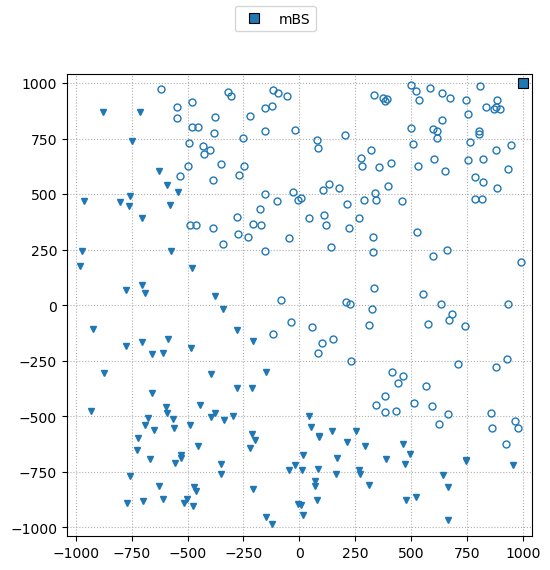

In [4]:
from pettingzoo import ParallelEnv
from ppo_sagin_v1_1 import *
from envs.sagin_v1 import *
from envs.utils import *
from copy import deepcopy

class StationaryUAVs:
    def __init__(self, env:ParallelEnv) -> None:
        self.env = env
        self.n_uavs = env.unwrapped.n_uavs
        self._action_to_direction = deepcopy(env.unwrapped._action_to_direction)
        self.stationary_action_id = self.get_stationary_action_id()
    
    def get_actions(self):
        actions = {}
        for i in range(self.n_uavs):
            actions["uav_" + str(i)] = self.stationary_action_id

        return actions

    def get_stationary_action_id(self):
        """Get the id of the stationary decision (no movement)."""
        for id, action in self.env.unwrapped._action_to_direction.items():
            if np.all(action == np.array([0, 0])):
                return id

""" ENV SETUP """
env = parallel_env(
    seed=seed,
    max_cycles=max_cycles,
    uav_init_mode = uav_init_mode,
    uav_init_locs=uav_init_locs,
    link_assignment=link_assignment,
    user_mode=user_mode,
    user_velocity=user_velocity,
    fading=fading,
)
obs, infos = env.reset(seed=None)

""" K-MEANS AGENT """
agent = StationaryUAVs(env=env)

""" TEST THE AGENT IN A NEW ENV """
step = 0
log_uav_locs = []
log_drates = []
log_avg_drates = []
log_n_satisfied = []

with torch.no_grad():
    # obs = batchify_obs(obs, device)
    terms = [False]
    truncs = [False]
    while not any(terms) and not any(truncs):
        log_uav_locs.append(env.unwrapped.locs['uav'].copy())
        log_drates.append(env.unwrapped.infos['global']['drates'])
        log_avg_drates.append(env.unwrapped.infos['global']['drate_avg'])
        log_n_satisfied.append(env.unwrapped.infos['global']['n_satisfied'])

        actions = agent.get_actions()
        obs, rewards, terms, truncs, infos = env.step(actions)
        terms = [terms[a] for a in terms]
        truncs = [truncs[a] for a in truncs]
        
        step += 1

    env.close()

""" PLOTTING """
fpath = 'comp/no_uavs.pdf'
plot_uav_movements(env, log_uav_locs=[], fpath=fpath, legend=True)
log_avg_drates_dict["No UAVs"] = log_avg_drates
log_n_satisfied_dict["No UAVs"] = log_n_satisfied
# plot_stats(env, log_avg_drates_dict, log_n_satisfied_dict)

In [5]:
# fpath = 'comp/no_uavs.pdf'
# plot_uav_movements(env, log_uav_locs=[], fpath=fpath, legend=False,\
#     fontsize=12, markersize=7)


### Kmeans

c:\Users\linhh\anaconda3\envs\gymnasium-env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\linhh\anaconda3\envs\gymnasium-env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\linhh\anaconda3\envs\gymnasium-env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\linhh\anaconda3\envs\gymnasium-env\lib\site-packages\sklearn\cluster\_

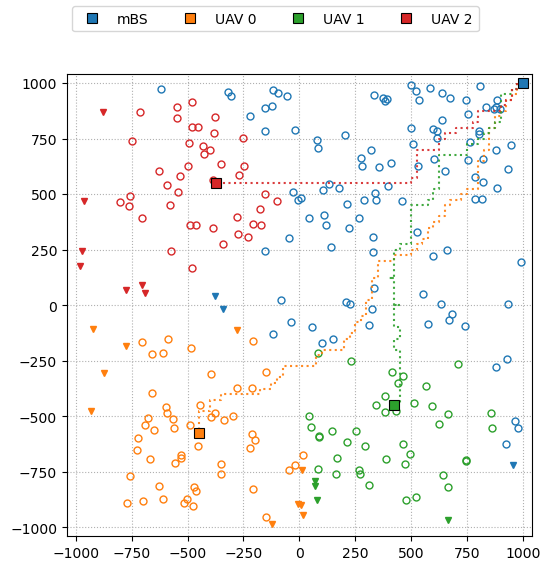

In [6]:
from kmeans import *

""" ENV SETUP """
env = parallel_env(
    seed=seed,
    max_cycles=max_cycles,
    uav_init_mode=uav_init_mode,
    uav_init_locs=uav_init_locs,
    link_assignment=link_assignment,
    user_mode=user_mode,
    user_velocity=user_velocity,
    fading=fading,
)
obs, infos = env.reset(seed=None)

""" K-MEANS AGENT """
agent = Kmeans_Agent(env=env)

""" TEST THE AGENT IN A NEW ENV """
step = 0
log_uav_locs = []
log_drates = []
log_avg_drates = []
log_n_satisfied = []

with torch.no_grad():
    # obs = batchify_obs(obs, device)
    terms = [False]
    truncs = [False]
    while not any(terms) and not any(truncs):
        # loggging
        log_uav_locs.append(env.unwrapped.locs['uav'].copy())
        log_drates.append(env.unwrapped.infos['global']['drates'])
        log_avg_drates.append(env.unwrapped.infos['global']['drate_avg'])
        log_n_satisfied.append(env.unwrapped.infos['global']['n_satisfied'])

        actions = agent.get_actions(
            user_locs=env.unwrapped.locs['user'],
            mbs_locs=env.unwrapped.locs['mbs'],
            uav_locs=env.unwrapped.locs['uav']
        )
        obs, rewards, terms, truncs, infos = env.step(actions)
        # obs = batchify_obs(obs, device)
        terms = [terms[a] for a in terms]
        truncs = [truncs[a] for a in truncs]

        step += 1

    env.close()

""" PLOTTING """
fpath = 'comp/kmeans.pdf'
plot_uav_movements(env, log_uav_locs, fpath)
log_avg_drates_dict["K-Greedy"] = log_avg_drates
log_n_satisfied_dict["K-Greedy"] = log_n_satisfied
# plot_stats(env, log_avg_drates_dict, log_n_satisfied_dict)

### Kmeans + PPO (SARL)

c:\Users\linhh\anaconda3\envs\gymnasium-env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\linhh\anaconda3\envs\gymnasium-env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\linhh\anaconda3\envs\gymnasium-env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\linhh\anaconda3\envs\gymnasium-env\lib\site-packages\sklearn\cluster\_

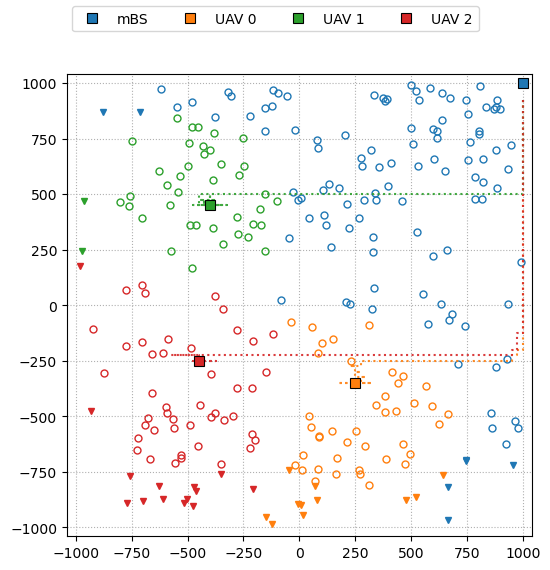

In [7]:
from kmeans_sb3_sarl import *
from stable_baselines3 import PPO


""" ENV SETUP """
env = parallel_env(
    seed=seed,
    max_cycles=max_cycles,
    uav_init_mode=uav_init_mode,
    uav_init_locs=uav_init_locs,
    link_assignment=link_assignment,
    user_mode=user_mode,
    user_velocity=user_velocity,
    fading=fading,
)
obs, infos = env.reset(seed=None)

""" AGENT SETUP """
fpath = "sarl/trained_agents/stable/ppo_2560k_max_drate"
# fpath = "sarl/trained_agents/stable/ppo_1280k_max_drate_fading"
# fpath = "sarl/trained_agents/stable/ppo_2560k_max_drate_fading"
model = PPO.load(fpath)
agent = Kmeans_SB3_Agent(env=env, model=model)

""" TEST THE AGENT IN A NEW ENV """
step = 0
log_uav_locs = []
log_drates = []
log_avg_drates = []
log_n_satisfied = []

with torch.no_grad():
    # obs = batchify_obs(obs, device)
    terms = [False]
    truncs = [False]
    while not any(terms) and not any(truncs):
        # loggging
        log_uav_locs.append(env.unwrapped.locs['uav'].copy())
        log_drates.append(env.unwrapped.infos['global']['drates'])
        log_avg_drates.append(env.unwrapped.infos['global']['drate_avg'])
        log_n_satisfied.append(env.unwrapped.infos['global']['n_satisfied'])

        actions = agent.get_actions(
            user_locs=env.unwrapped.locs['user'],
            mbs_locs=env.unwrapped.locs['mbs'],
            uav_locs=env.unwrapped.locs['uav'],
            deterministic=deterministic
        )
        obs, rewards, terms, truncs, infos = env.step(actions)
        # obs = batchify_obs(obs, device)
        terms = [terms[a] for a in terms]
        truncs = [truncs[a] for a in truncs]

        step += 1

    env.close()

""" PLOTTING """
fpath = 'comp/kmeans_sb3_sarl.pdf'
plot_uav_movements(env, log_uav_locs, fpath)
log_avg_drates_dict["K-SARL"] = log_avg_drates
log_n_satisfied_dict["K-SARL"] = log_n_satisfied
# plot_stats(env, log_avg_drates_dict, log_n_satisfied_dict)

### MA-PPO (Proposed)

C:\Users\linhh\AppData\Local\Temp\ipykernel_31808\1382689017.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(PATH, map_location=torch.device('cp

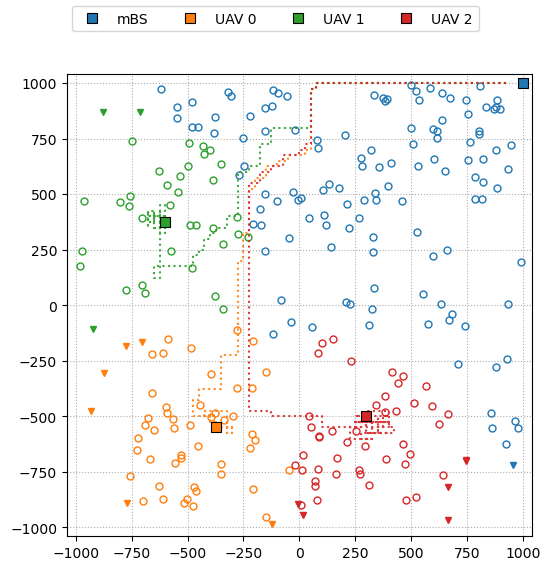

In [11]:
from envs.sagin_v1 import *
from envs.utils import *
from ppo_sagin_v1_1 import *

device = torch.device('cpu')   # 'cpu' or 'cuda'
# torch.set_default_dtype(torch.float64)

""" ENV SETUP """
env = parallel_env(
    seed=seed,
    max_cycles=max_cycles,
    uav_init_mode=uav_init_mode,
    uav_init_locs=uav_init_locs,
    link_assignment=link_assignment,
    user_mode=user_mode,
    user_velocity=user_velocity,
    fading=fading,
    animation=True
)
obs, infos = env.reset(seed=None)
num_agents = len(env.possible_agents)
num_actions = env.action_space(env.possible_agents[0]).n
obs_shape = env.observation_space(env.possible_agents[0]).shape

""" LOAD THE TRAINED AGENT """
agent = Agent(obs_len=obs_shape[0], num_actions=num_actions).to(device)

# folder = "20240318-044445 (20k, run 1)"                   # stable
# folder = "20240319-060814 (20k, run 2)"
# folder = "20240319-181056 (20k, run 3)"
# folder = "20240320-102038 (30k, run 1)"
# folder = "20240321-065743 (30k, run 2)"
# folder = "20240322-072249 (20k, run  5, dr_rw=0.8)"
# folder = "20240323-034204 (20k, run 6, dr_rw=0.2)"
# folder = "20240323-175732 (20k, run 7, dr_rw=0.2)"
# folder = "20240330-004546 (20k runs, 64-64)"              # bad performance
# folder = "20240330-213507 (20k, no fading)"
# folder = "20240331-053649 (20k, no fading, dr_rw=0)"
folder = "20240331-194308 (10k, fading, dr_rw=0, local_rw=0.1)"         # stable 2
# folder = "20240401-051329 (10k, fading, dr_rw=0, local_rw=0)"   # perform good in worse cases
# folder = "20240402-082347 (20k, fading, dr_rw=0, local_rw=0, 256 steps)"      # kinda overfitting


### not statble if starting from the top-right corner, why?
# folder = "20240321-200529 (20k, run 4, lr=5e-4)"

PATH = "trained_agents/selected/" + folder + "/model.tar"
checkpoint = torch.load(PATH, map_location=torch.device('cpu'))
agent.load_state_dict(checkpoint['model_state_dict'])
agent.eval()

""" TEST THE AGENT IN A NEW ENV """
step = 0
log_uav_locs = []
log_user_locs = []
log_drates = []
log_avg_drates = []
log_n_satisfied = []

with torch.no_grad():
    obs = batchify_obs(obs, device)
    terms = [False]
    truncs = [False]
    while not any(terms) and not any(truncs):
        # loggging
        log_uav_locs.append(env.unwrapped.locs['uav'].copy())
        log_user_locs.append(env.unwrapped.locs['user'].copy())
        log_drates.append(env.unwrapped.infos['global']['drates'])
        log_avg_drates.append(env.unwrapped.infos['global']['drate_avg'])
        log_n_satisfied.append(env.unwrapped.infos['global']['n_satisfied'])

        actions, logprobs, _, values = agent.get_action_and_value(obs, deterministic=deterministic)
        obs, rewards, terms, truncs, infos = env.step(unbatchify(actions, env))
        obs = batchify_obs(obs, device)
        terms = [terms[a] for a in terms]
        truncs = [truncs[a] for a in truncs]
        
        step += 1

    env.close()

""" PLOTTING """
fpath = 'comp/marl.pdf'
plot_uav_movements(env, log_uav_locs, fpath)
log_avg_drates_dict["MARL (Proposed)"] = log_avg_drates
log_n_satisfied_dict["MARL (Proposed)"] = log_n_satisfied
# plot_stats(env, {"MARL": log_avg_drates}, {"MARL": log_n_satisfied})


In [ ]:
# fpath = 'comp/marl.pdf'
# plot_uav_movements(env, log_uav_locs, fpath, fontsize=12, markersize=7, linewidth=2.5)


In [ ]:
# env.unwrapped.plot_animation(filename='tmp/animation.gif', interval=100)

### Random Movements

In [ ]:
# from pettingzoo import ParallelEnv
# from ppo_sagin_v1_1 import *
# from envs.sagin_v1 import *
# from envs.utils import *
# from copy import deepcopy

# class RandomMovements:
#     def __init__(self, env:ParallelEnv) -> None:
#         self.env = env
#         self.n_uavs = env.unwrapped.n_uavs
#         self.n_actions = env.action_space(env.possible_agents[0]).n

#     def get_actions(self):
#         actions = {}
#         for i in range(self.n_uavs):
#             actions["uav_" + str(i)] = np.random.choice(self.n_actions)

#         return actions

# """ ENV SETUP """
# env = parallel_env(
#     seed=seed,
#     max_cycles=max_cycles,
#     uav_init_mode = uav_init_mode,
#     uav_init_locs=uav_init_locs,
#     user_mode=user_mode,
#     user_velocity=user_velocity
# )
# obs, infos = env.reset(seed=None)

# """ K-MEANS AGENT """
# agent = RandomMovements(env=env)

# """ TEST THE AGENT IN A NEW ENV """
# step = 0
# log_uav_locs = []
# log_drates = []
# log_avg_drates = []
# log_n_satisfied = []

# with torch.no_grad():
#     # obs = batchify_obs(obs, device)
#     terms = [False]
#     truncs = [False]
#     while not any(terms) and not any(truncs):
#         log_uav_locs.append(env.unwrapped.locs['uav'].copy())
#         log_drates.append(env.unwrapped.infos['global']['drates'])
#         log_avg_drates.append(env.unwrapped.infos['global']['drate_avg'])
#         log_n_satisfied.append(env.unwrapped.infos['global']['n_satisfied'])

#         actions = agent.get_actions()
#         obs, rewards, terms, truncs, infos = env.step(actions)
#         terms = [terms[a] for a in terms]
#         truncs = [truncs[a] for a in truncs]
        
#         step += 1

#     env.close()

# """ PLOTTING """
# fpath = 'comp/random_movements.png'
# plot_uav_movements(env, log_uav_locs, fpath, legend=False)
# log_avg_drates_dict["Random Movements"] = log_avg_drates
# log_n_satisfied_dict["Random Movements"] = log_n_satisfied
# # plot_stats(env, log_avg_drates_dict, log_n_satisfied_dict)

# Performance Comparison

### Percentage of satisfied users

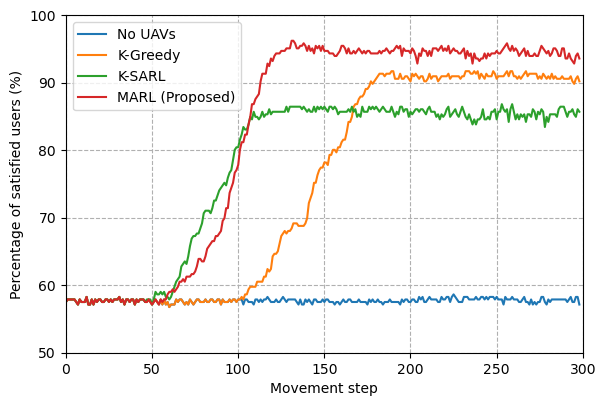

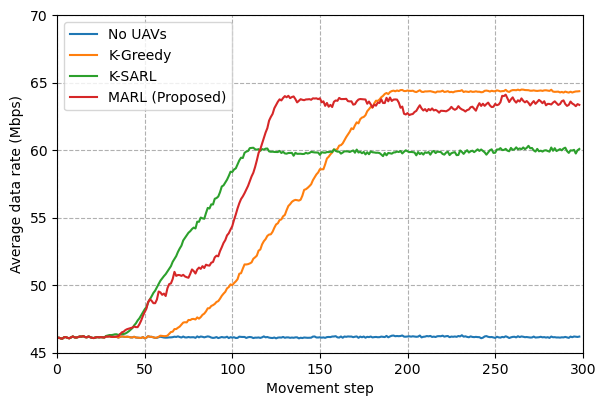

In [19]:
import pandas as pd
import os

def to_excel(kpis, path):
    for name, kpi in kpis.items():
        df = pd.DataFrame(kpi)
        df.to_excel(path + f"{name}.xlsx")

path = "comp/"
kpis = {
    "avg_data_rate": log_avg_drates_dict,
    "n_satisfied_users": log_n_satisfied_dict
}
to_excel(kpis=kpis, path=path)
plot_stats(env, log_avg_drates_dict, log_n_satisfied_dict, path=path)

# print(f"saved data to {os.path.join(os.getcwd(), path)}")


### Accumulated stats

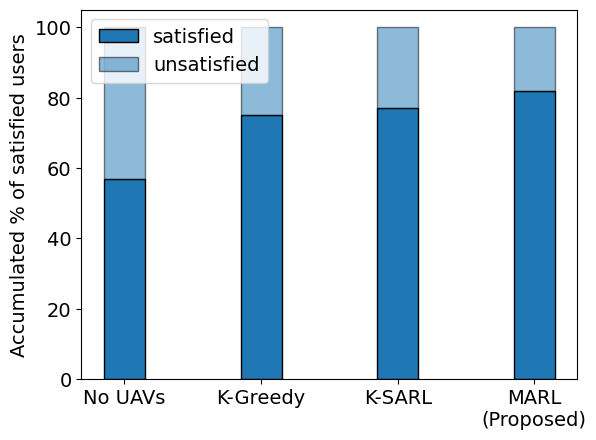

In [20]:
fig, ax = plt.subplots(figsize=(6.4, 4.8))

groups = ['No UAVs', 'K-Greedy', 'K-SARL', 'MARL\n(Proposed)']
values1 = np.array([57, 75, 77, 82])
values2 = 100 - values1
width = 0.3
fontsize=14

ax.bar(groups, values1, label='satisfied',
       color="tab:blue",  edgecolor = "black", width= width)
ax.bar(groups, values2, label='unsatisfied',
       color="tab:blue",  edgecolor = "black", width= width, bottom=values1, alpha=0.5)

ax.set_ylabel('Accumulated % of satisfied users', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
ax.set_ylim(bottom=0)
ax.legend(loc="upper left", fontsize=fontsize)

plt.savefig("comp/accumulated.pdf")
plt.show()

                 percentage  drate_Mbps
method                                 
No UAVs           57.711168   46.159145
K-Greedy          74.960394   56.438643
K-SARL            77.765484   56.536148
MARL (Proposed)   82.748259   58.082599
(n_users: 266)


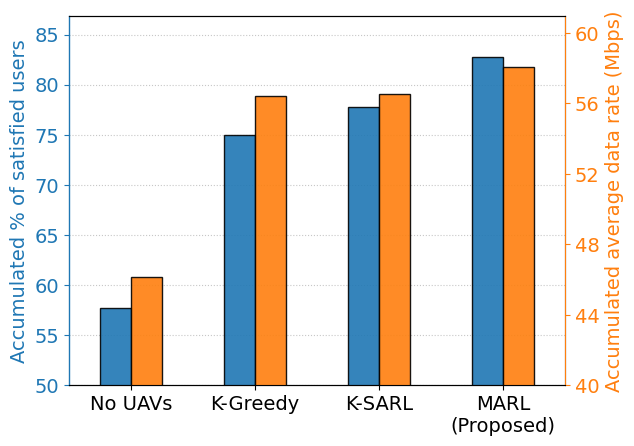

In [21]:
import matplotlib.pyplot as plt 
import pandas as pd 
  
width = 0.25
fontsize = 14
n_users = env.unwrapped.n_users

# df = pd.DataFrame([['No UAVs', 10, 200],
#                    ['K-Greedy', 20, 250],
#                    ['K-SARL', 12, 150], 
#                    ['MARL\n(Proposed)', 10, 290]], 
#                   columns=['method', 'percentage', 'drate_Mbps'])
# df = df.set_index("method")

df = pd.DataFrame({
    'method': [],
    'percentage': [],
    'drate_Mbps': [],
})

for method in log_n_satisfied_dict.keys():
    df2 = pd.DataFrame({
        "method": [method],
        'percentage': [np.mean(log_n_satisfied_dict[method])/n_users*100],
        'drate_Mbps': [np.mean(log_avg_drates_dict[method])/1e6],
    })
    df = pd.concat([df,df2])
df = df.set_index("method")

print(df)
print(f"(n_users: {n_users})")

fig = plt.figure(figsize=(6.4, 4.8))

ax = fig.add_subplot(111) 
ax2 = ax.twinx()

df.percentage.plot(kind='bar', color='tab:blue', ax=ax, width=width, position=1,
                   fontsize=fontsize, rot=0, edgecolor='k', alpha=0.9)
df.drate_Mbps.plot(kind='bar', color='tab:orange', ax=ax2, width=width, position=0,
              fontsize=fontsize, rot=0, edgecolor='k', alpha=0.9)

ax.set_ylabel('Accumulated % of satisfied users', fontsize=fontsize)
ax2.set_ylabel('Accumulated average data rate (Mbps)', fontsize=fontsize)

ax.set_xlabel("")
ax.set_xlim(left=-0.5, right=3.5)
ax.set_ylim(bottom=50)
ax2.set_ylim(bottom=40)
ax2.set_yticks(range(40, 61, 4))

# wrapped text for MARL\n(Proposed)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[-1] = 'MARL\n(Proposed)'
ax.set_xticklabels(labels)

ax.yaxis.label.set_color('tab:blue')
ax.tick_params(axis='y', colors='tab:blue')

ax.spines['left'].set_color('tab:blue')
ax2.spines['right'].set_color('None')
ax.spines['left'].set_lw(1)

ax2.yaxis.label.set_color('tab:orange')
ax2.tick_params(axis='y', colors='tab:orange')

ax2.spines['left'].set_color('None')
ax2.spines['right'].set_color('tab:orange')
ax.spines['left'].set_lw(1)

# ax.grid(True, linestyle=":")
ax.yaxis.grid(True, linestyle=":", alpha=0.7)
ax.set_axisbelow(True)

fig.savefig('comp/accumulated2.pdf', bbox_inches = 'tight')


# df.plot(
#     kind= 'bar' ,
#     secondary_y= 'drate' ,
#     rot= 0,
#     width=0.5,
#     xlabel="",
#     legend=False,
#     mark_right=False,
#     fontsize=fontsize,
#     edgecolor='k',
# )


### Training logs

run 1: selected_Mar17_21-28-40_ccl-ubuntu-20-04 (20k, run 1).csv
run 2: selected_Mar18_22-31-18_ccl-ubuntu-20-04 (20k, run 2).csv
run 3: selected_Mar20_19-36-16_ccl-ubuntu-20-04 (30k, run 2).csv
run 4: selected_Mar21_12-54-17_ccl-ubuntu-20-04 (20k, run 4, lr=0.5e-3).csv
run 5: selected_Mar23_10-11-26_ccl-ubuntu-20-04 (20k, run 7, dr_rw=0.2).csv


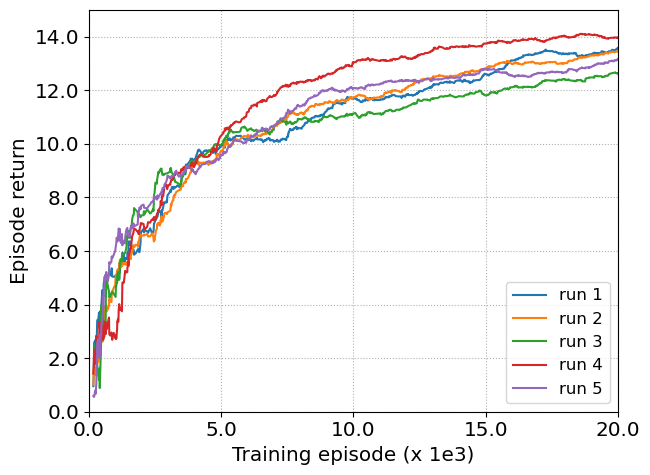

run 1: selected_Mar17_21-28-40_ccl-ubuntu-20-04 (20k, run 1).csv
run 2: selected_Mar18_22-31-18_ccl-ubuntu-20-04 (20k, run 2).csv
run 3: selected_Mar20_19-36-16_ccl-ubuntu-20-04 (30k, run 2).csv
run 4: selected_Mar21_12-54-17_ccl-ubuntu-20-04 (20k, run 4, lr=0.5e-3).csv
run 5: selected_Mar23_10-11-26_ccl-ubuntu-20-04 (20k, run 7, dr_rw=0.2).csv


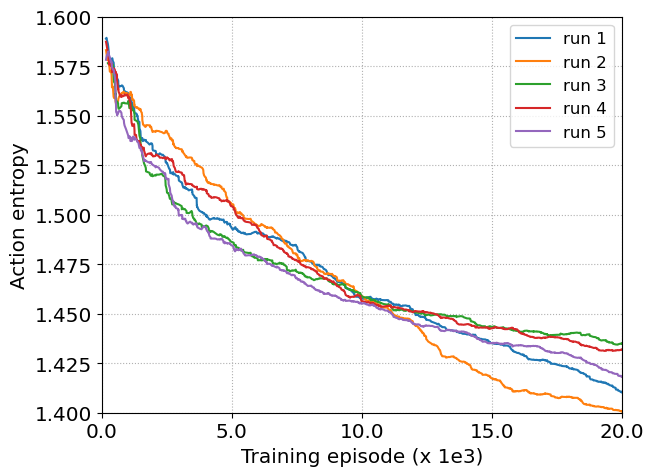

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# figsize = (5, 3)

""" PLOT EPISODE RETURN """
fpath = "runs/selected/episode_return/"
files = os.listdir(fpath)    
csv_files = list(filter(lambda f: f.endswith('.csv'), files))
fig, ax = plt.subplots()
i = 1
for fname in csv_files:
    print(f"run {i}: {fname}")
    df = pd.read_csv(fpath + fname)
    # plt.plot(df.Step, df.Value)
    plt.plot(
        df.Step,
        df.Value.ewm(alpha=0.001, adjust=True, min_periods=10).mean(),
        label=f"run {i}"
    )
    i += 1
plt.xlabel('Training episode (x 1e3)', fontsize='x-large')
plt.ylabel('Episode return', fontsize='x-large')
locs, labels = plt.xticks()
ax.set_xticks(locs, locs/1e3)
locs, labels = plt.yticks()
ax.set_yticks(locs, locs)
ax.set_xlim([0, 20000])
ax.set_ylim(bottom=0, top=15)
ax.margins(0, 0)
plt.grid(visible=True, linestyle=':')
ax.legend(loc='lower right', fontsize='large')
fig.tight_layout()
plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.savefig("comp/" + "episode_return.pdf")
plt.show()

""" PLOT ENTROPY """
fpath = "runs/selected/entropy/"
files = os.listdir(fpath)    
csv_files = list(filter(lambda f: f.endswith('.csv'), files))
fig, ax = plt.subplots()
i = 1
for fname in csv_files:
    print(f"run {i}: {fname}")
    df = pd.read_csv(fpath + fname)
    # plt.plot(df.Step, df.Value)
    plt.plot(
        df.Step,
        df.Value.ewm(alpha=0.001, adjust=True, min_periods=10).mean(),
        label=f"run {i}"
    )
    i += 1
plt.xlabel('Training episode (x 1e3)', fontsize='x-large')
plt.ylabel('Action entropy', fontsize='x-large')
locs, labels = plt.xticks()
ax.set_xticks(locs, locs/1e3)
# locs, labels = plt.yticks()
# ax.set_yticks(locs, locs)
ax.set_xlim([0, 20000])
ax.set_ylim(bottom=1.4, top=1.6)
ax.margins(0, 0)
plt.grid(visible=True, linestyle=':')
ax.legend(loc='upper right', fontsize='large')
fig.tight_layout()
plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.savefig("comp/" + "action_entropy.pdf")
plt.show()
